<font color=#7325FC>**Arquitetura SOMLSTM e visão geral de implementação**</font>

O objetivo deste <i>notebook</i> é apresentar os métodos empregados para predição de eventos extremos,<br>utilizando os dados das estações meteorológicas mantidas pelo COR na cidade do Rio de Janeiro.

**Índice**:

*   Apresentação do conjunto de dados utilizado
*   Estudo do desbalanceamento dos dados
*   Rede neural Mapa auto-organizável
*   Rede neural profunda LSTM
*   Análise dos resultados
*   Considerações

In [ ]:
print("**********************************************************************")
print("* LNCC - DEXL: Study of Anomalies                                    *")
print("**********************************************************************")
print("* Event:     Internal Workshop - COR/LNCC/CEFET-RJ/Geo-Rio/AlertaRio *")
print("* Author:    Thiago Moeda                                            *")
print("* Advisors:  Fabio Porto and Eduardo Ogasawara                       *")
print("* Date:      23/07/2021                                              *")
print("**********************************************************************")

**********************************************************************
* LNCC - DEXL: Study of Anomalies                                    *
**********************************************************************
* Event:     Internal Workshop - COR/LNCC/CEFET-RJ/Geo-Rio/AlertaRio *
* Author:    Thiago Moeda                                            *
* Advisors:  Fabio Porto and Eduardo Ogasawara                       *
* Date:      23/07/2021                                              *
**********************************************************************


In [ ]:
import sys
from google.colab import drive
from IPython.display import Image

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/Colab Notebooks')
ENV_PATH = "/content/gdrive/MyDrive/Colab Notebooks/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhtS9hSg61gw9uqWE-X2Hb6PoKOWNyZCLadwF660BCVa7qv6CHjLN8
Mounted at /content/gdrive/


In [ ]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from platform import python_version
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams.update({"font.size": 18})

print(". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .")
print("Environment and Libraries:")
print()
print("     Environment      ==      Colaboratory Google Research")
print("     python version   ==      "+python_version())
print("     pandas           ==      %s" % pd.__version__)
print("     numpy            ==      %s" % np.__version__)
print("     sklearn          ==      %s" % sklearn.__version__)
print("     tensorflow       ==      %s" % keras.__version__)
print(". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .")
print()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Environment and Libraries:

     Environment      ==      Colaboratory Google Research
     python version   ==      3.7.11
     pandas           ==      1.1.5
     numpy            ==      1.19.5
     sklearn          ==      0.22.2.post1
     tensorflow       ==      2.5.0
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



In [1]:
Image(ENV_PATH+"/img/estacoes_cor.png")

NameError: ignored

In [ ]:

attr = ["Chuva_alto_da_boa_vista",  "Temperatura_alto_da_boa_vista",  "Umidade_alto_da_boa_vista",
        "Chuva_guaratiba",          "Temperatura_guaratiba",          "Umidade_guaratiba",
        "Chuva_iraja",              "Temperatura_iraja",              "Umidade_iraja",
        "Chuva_jardim_botanico",    "Temperatura_jardim_botanico",    "Umidade_jardim_botanico",
        "Chuva_rio_centro",         "Temperatura_rio_centro",         "Umidade_rio_centro",
        "Chuva_santa_cruz",         "Temperatura_santa_cruz",         "Umidade_santa_cruz",
        "Chuva_sao_cristovao",      "Temperatura_sao_cristovao",      "Umidade_sao_cristovao"]

features = pd.read_csv(ENV_PATH+"dat/2021.csv", encoding = 'utf-8', usecols=attr)

print("------------------------------------------------")
print("Basic description of features:")
print("------------------------------------------------")
print("Dataset shape:           ", features.shape)
print("Total samples:           ", len(features))
print("Total attributes:        ", np.size(attr))
print("------------------------------------------------")
print("Nullity:")
print()
print(features.isnull().sum())
print("------------------------------------------------")

------------------------------------------------
Basic description of features:
------------------------------------------------
Dataset shape:            (7296, 21)
Total samples:            7296
Total attributes:         21
------------------------------------------------
Nullity:

Chuva_alto_da_boa_vista             0
Temperatura_alto_da_boa_vista       0
Umidade_alto_da_boa_vista           0
Chuva_guaratiba                     0
Temperatura_guaratiba               0
Umidade_guaratiba                5412
Chuva_iraja                        45
Temperatura_iraja                1074
Umidade_iraja                     278
Chuva_jardim_botanico               0
Temperatura_jardim_botanico         0
Umidade_jardim_botanico             0
Chuva_rio_centro                    0
Temperatura_rio_centro              0
Umidade_rio_centro                  0
Chuva_santa_cruz                    0
Temperatura_santa_cruz            655
Umidade_santa_cruz                  0
Chuva_sao_cristovao            

In [ ]:
features.head()

In [ ]:
from sklearn.impute import SimpleImputer
imp   = SimpleImputer(missing_values=np.nan, strategy='mean')
imp   = imp.fit(features)    
impX  = imp.transform(features)
X     = pd.DataFrame(impX, columns = attr)

In [ ]:
attr_timestamp  = ["Timestamp"]
timeStamp       = pd.read_csv(ENV_PATH+"/dat/2021.csv", encoding = 'utf-8', usecols=attr_timestamp)
X               = X.join(timeStamp)
X["Timestamp"]  = pd.to_datetime(X["Timestamp"])
X.index         = X["Timestamp"]
print(X.isnull().sum())

Chuva_alto_da_boa_vista          0
Temperatura_alto_da_boa_vista    0
Umidade_alto_da_boa_vista        0
Chuva_guaratiba                  0
Temperatura_guaratiba            0
Umidade_guaratiba                0
Chuva_iraja                      0
Temperatura_iraja                0
Umidade_iraja                    0
Chuva_jardim_botanico            0
Temperatura_jardim_botanico      0
Umidade_jardim_botanico          0
Chuva_rio_centro                 0
Temperatura_rio_centro           0
Umidade_rio_centro               0
Chuva_santa_cruz                 0
Temperatura_santa_cruz           0
Umidade_santa_cruz               0
Chuva_sao_cristovao              0
Temperatura_sao_cristovao        0
Umidade_sao_cristovao            0
Timestamp                        0
dtype: int64


In [ ]:
print("------------------------------------------------")
print("Total period of time:")    
print("------------------------------------------------")
print() 
beginDate   = X.iloc[0]["Timestamp"]
endDate     = X.iloc[-1]["Timestamp"]
print("Begin Date: ", beginDate)
print("End Date:   ", endDate)
print("------------------------------------------------")

------------------------------------------------
Total period of time:
------------------------------------------------

Begin Date:  2021-01-01 00:00:00
End Date:    2021-03-17 23:45:00
------------------------------------------------


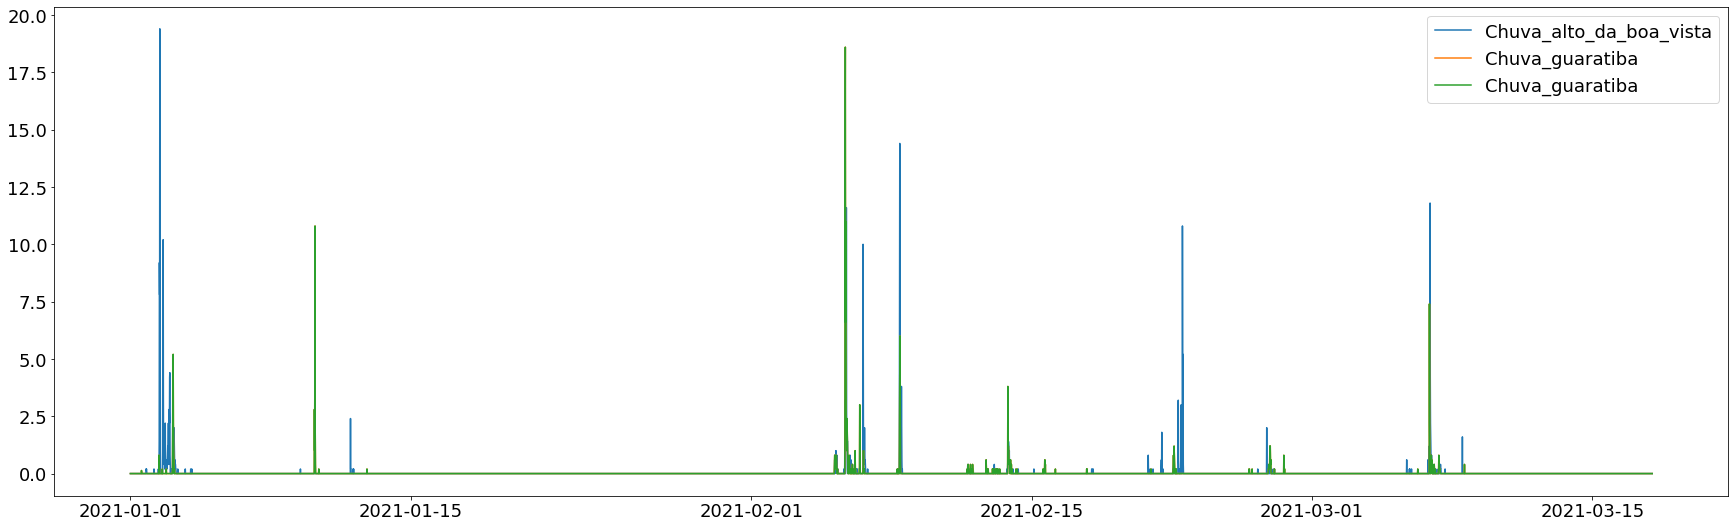

In [ ]:
plt.rcParams["figure.figsize"] = (30,9)
plt.plot(X["Timestamp"], X["Chuva_alto_da_boa_vista"], label="Chuva_alto_da_boa_vista")
plt.plot(X["Timestamp"], X["Chuva_guaratiba"], label="Chuva_guaratiba")
plt.plot(X["Timestamp"], X["Chuva_guaratiba"], label="Chuva_guaratiba")
plt.legend(loc="best")
plt.show()

In [ ]:
print("------------------------------------------------")
print("Selecting a date range:")
print("------------------------------------------------")
filterBeginDate     = "2021-01-02 00:00:00"
filterEndDate       = "2021-01-03 12:00:00"
all_data_range      = X[(X.index.get_level_values(0) >= filterBeginDate) & (X.index.get_level_values(0) <= filterEndDate)]
beginDateR          = all_data_range.iloc[0]["Timestamp"]
endDateR            = all_data_range.iloc[-1]["Timestamp"]
print("Begin Date: ", beginDateR)
print("End Date:   ", endDateR)
print("------------------------------------------------")

------------------------------------------------
Selecting a date range:
------------------------------------------------
Begin Date:  2021-01-02 00:00:00
End Date:    2021-01-03 12:00:00
------------------------------------------------


In [ ]:
print("------------------------------------------------")
print("Selecting a date range:")
print("------------------------------------------------")
filterBeginDate     = "2021-02-05 00:00:00"
filterEndDate       = "2021-02-08 23:45:00"
all_data_range2     = X[(X.index.get_level_values(0) >= filterBeginDate) & (X.index.get_level_values(0) <= filterEndDate)]
beginDateR          = all_data_range2.iloc[0]["Timestamp"]
endDateR            = all_data_range2.iloc[-1]["Timestamp"]
print("Begin Date: ", beginDateR)
print("End Date:   ", endDateR)
print("------------------------------------------------")

------------------------------------------------
Selecting a date range:
------------------------------------------------
Begin Date:  2021-02-05 00:00:00
End Date:    2021-02-08 23:45:00
------------------------------------------------


**Média Móvel**


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


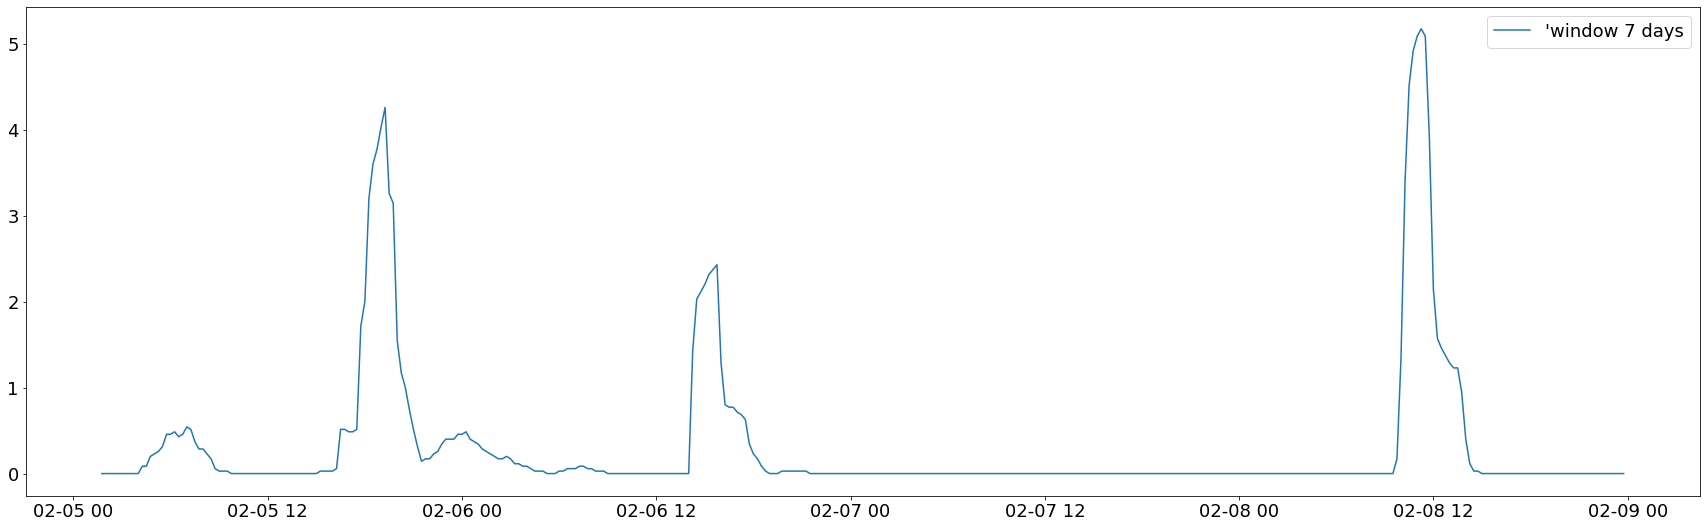

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


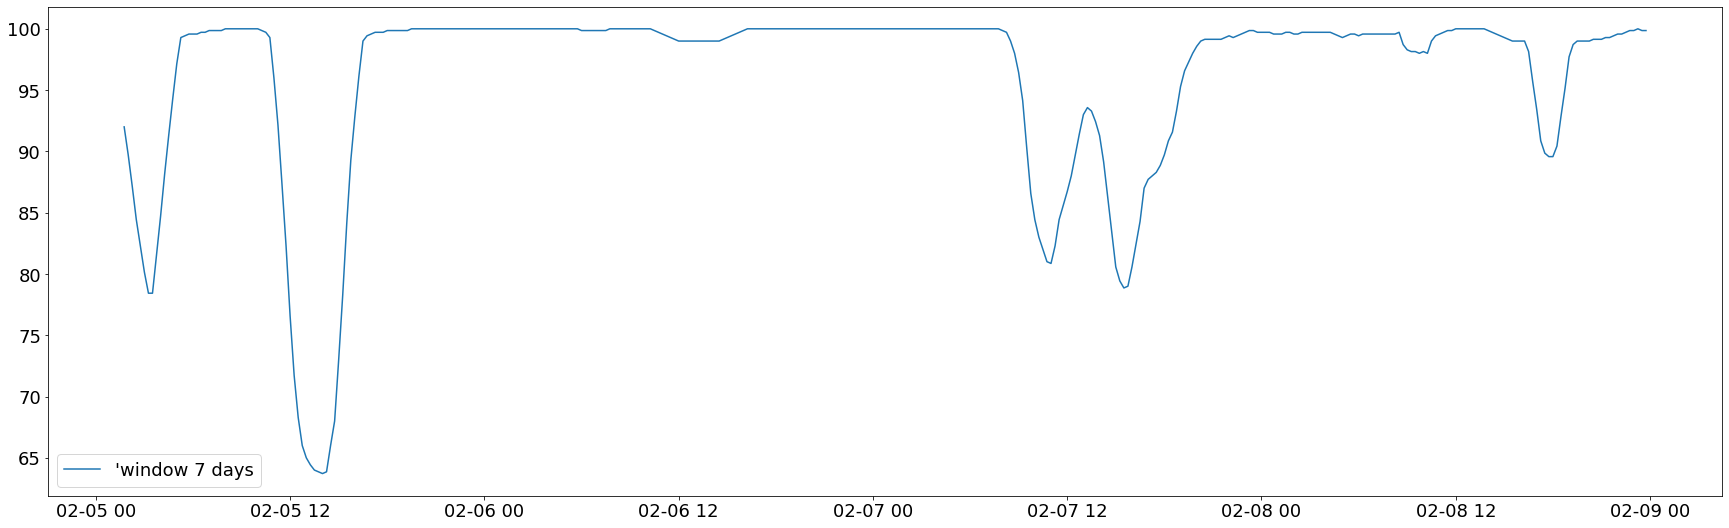

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


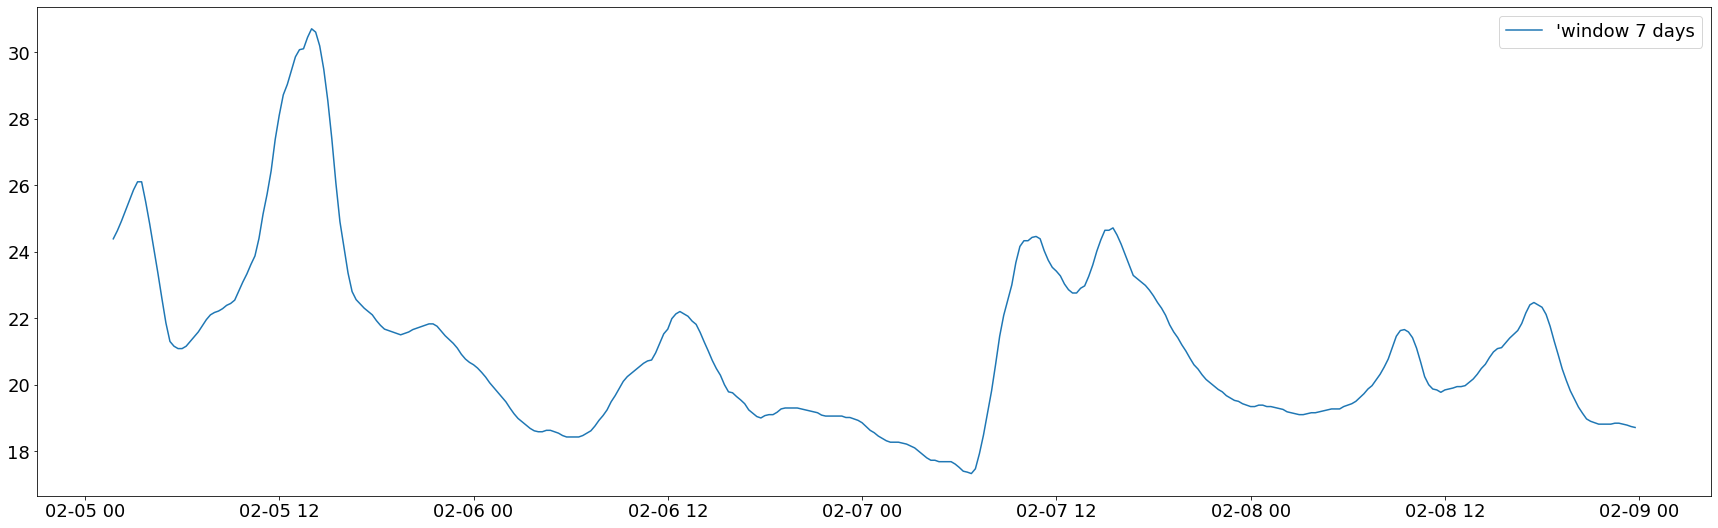

In [ ]:
plt.rcParams["figure.figsize"] = (30,9)
all_data_range2["mean_win"] = all_data_range2["Chuva_alto_da_boa_vista"].rolling(7).mean().shift()
#plt.plot(all_data_range2["Timestamp"], all_data_range2["Chuva_alto_da_boa_vista"], label="Chuva_alto_da_boa_vista")
plt.plot(all_data_range2["Timestamp"], all_data_range2["mean_win"], label="'window 7 days")
plt.legend(loc="best")
plt.show()

all_data_range2["mean_win"] = all_data_range2["Umidade_alto_da_boa_vista"].rolling(7).mean().shift()
#plt.plot(all_data_range2["Timestamp"], all_data_range2["Umidade_alto_da_boa_vista"], label="Umidade_alto_da_boa_vista")
plt.plot(all_data_range2["Timestamp"], all_data_range2["mean_win"], label="'window 7 days")
plt.legend(loc="best")
plt.show()

all_data_range2["mean_win"] = all_data_range2["Temperatura_alto_da_boa_vista"].rolling(7).mean().shift()
#plt.plot(all_data_range2["Timestamp"], all_data_range2["Temperatura_alto_da_boa_vista"], label="Temperatura_alto_da_boa_vista")
plt.plot(all_data_range2["Timestamp"], all_data_range2["mean_win"], label="'window 7 days")
plt.legend(loc="best")
plt.show()

In [ ]:
del attr
del X

# **Self-organizing Map**



In [ ]:
attr = ["Timestamp",
        "Chuva_alto_da_boa_vista",  "Temperatura_alto_da_boa_vista",  "Umidade_alto_da_boa_vista",
        "Chuva_guaratiba",          "Temperatura_guaratiba",          "Umidade_guaratiba",
        "Chuva_iraja",              "Temperatura_iraja",              "Umidade_iraja",
        "Chuva_jardim_botanico",    "Temperatura_jardim_botanico",    "Umidade_jardim_botanico",
        "Chuva_rio_centro",         "Temperatura_rio_centro",         "Umidade_rio_centro",
        "Chuva_santa_cruz",         "Temperatura_santa_cruz",         "Umidade_santa_cruz",
        "Chuva_sao_cristovao",      "Temperatura_sao_cristovao",      "Umidade_sao_cristovao"]

X = pd.read_csv(ENV_PATH+"/dat/2021.csv", encoding = 'utf-8', usecols=attr)

In [ ]:
print("------------------------------------------------")
print("Basic description of features:")
print("------------------------------------------------")
print("Dataset shape:           ", X.shape)
print("Total samples:           ", len(X))
print("Total attributes:        ", np.size(attr))
print("------------------------------------------------")
print("Nullity:")
print()
print(X.isnull().sum())
print("------------------------------------------------")

------------------------------------------------
Basic description of features:
------------------------------------------------
Dataset shape:            (7296, 22)
Total samples:            7296
Total attributes:         22
------------------------------------------------
Nullity:

Timestamp                           0
Chuva_alto_da_boa_vista             0
Temperatura_alto_da_boa_vista       0
Umidade_alto_da_boa_vista           0
Chuva_guaratiba                     0
Temperatura_guaratiba               0
Umidade_guaratiba                5412
Chuva_iraja                        45
Temperatura_iraja                1074
Umidade_iraja                     278
Chuva_jardim_botanico               0
Temperatura_jardim_botanico         0
Umidade_jardim_botanico             0
Chuva_rio_centro                    0
Temperatura_rio_centro              0
Umidade_rio_centro                  0
Chuva_santa_cruz                    0
Temperatura_santa_cruz            655
Umidade_santa_cruz             

In [ ]:
X.head()

,Timestamp,Chuva_alto_da_boa_vista,Temperatura_alto_da_boa_vista,Umidade_alto_da_boa_vista,Chuva_guaratiba,Temperatura_guaratiba,Umidade_guaratiba,Chuva_iraja,Temperatura_iraja,Umidade_iraja,Chuva_jardim_botanico,Temperatura_jardim_botanico,Umidade_jardim_botanico,Chuva_rio_centro,Temperatura_rio_centro,Umidade_rio_centro,Chuva_santa_cruz,Temperatura_santa_cruz,Umidade_santa_cruz,Chuva_sao_cristovao,Temperatura_sao_cristovao,Umidade_sao_cristovao
0,2021-01-01 00:00:00,0.0,20.500000,99.666667,0.0,22.433333,NaN,0.0,25.400000,83.666667,0.0,22.866667,93.000000,0.0,26.533333,76.333333,0.0,24.500000,91.333333,0.0,25.733333,81.000000
1,2021-01-01 00:15:00,0.0,20.500000,100.000000,0.0,22.400000,NaN,0.0,25.166667,85.000000,0.0,22.633333,94.000000,0.0,26.566667,77.000000,0.0,24.333333,92.000000,0.0,25.800000,81.000000
2,2021-01-01 00:30:00,0.0,20.366667,100.000000,0.0,22.266667,NaN,0.0,25.166667,85.333333,0.0,22.766667,93.666667,0.0,26.566667,76.666667,0.0,24.066667,92.666667,0.0,25.866667,81.000000
3,2021-01-01 00:45:00,0.0,20.300000,99.333333,0.0,22.166667,NaN,0.0,25.233333,85.333333,0.0,22.733333,92.666667,0.0,26.466667,77.000000,0.0,24.033333,93.000000,0.0,25.866667,81.666667
4,2021-01-01 01:00:00,0.0,20.166667,100.000000,0.0,22.033333,NaN,0.0,25.133333,86.000000,0.0,22.833333,93.000000,0.0,26.133333,76.333333,0.0,24.100000,93.000000,0.0,25.666667,82.000000


In [ ]:
#Pacote SOM_PAK

#{First stage: Map initialization}
#ENV_PATH+/lib/som_pak/randinit -din 2021.dat -cout 2021.cod -xdim 120 -ydim 120 -topol hexa -neigh gaussian -rand 123

#{Second stage: Map training}
#ENV_PATH+/lib/som_pak/vsom -din 2021.dat -cout 2021.cod -rlen 100 -alpha 0.45 -radius 12 -fixed

#{Third stage: Evaluation of the quantization error}
#ENV_PATH+/som_pak/qerror -din 2021.dat -cout 2021.cod > 2021.error

#{Fourth stage: Map visualization}
#ENV_PATH+/som_pak/visual -din 2021.dat -cout 2021.cod 2021.error -dout 2021.visual


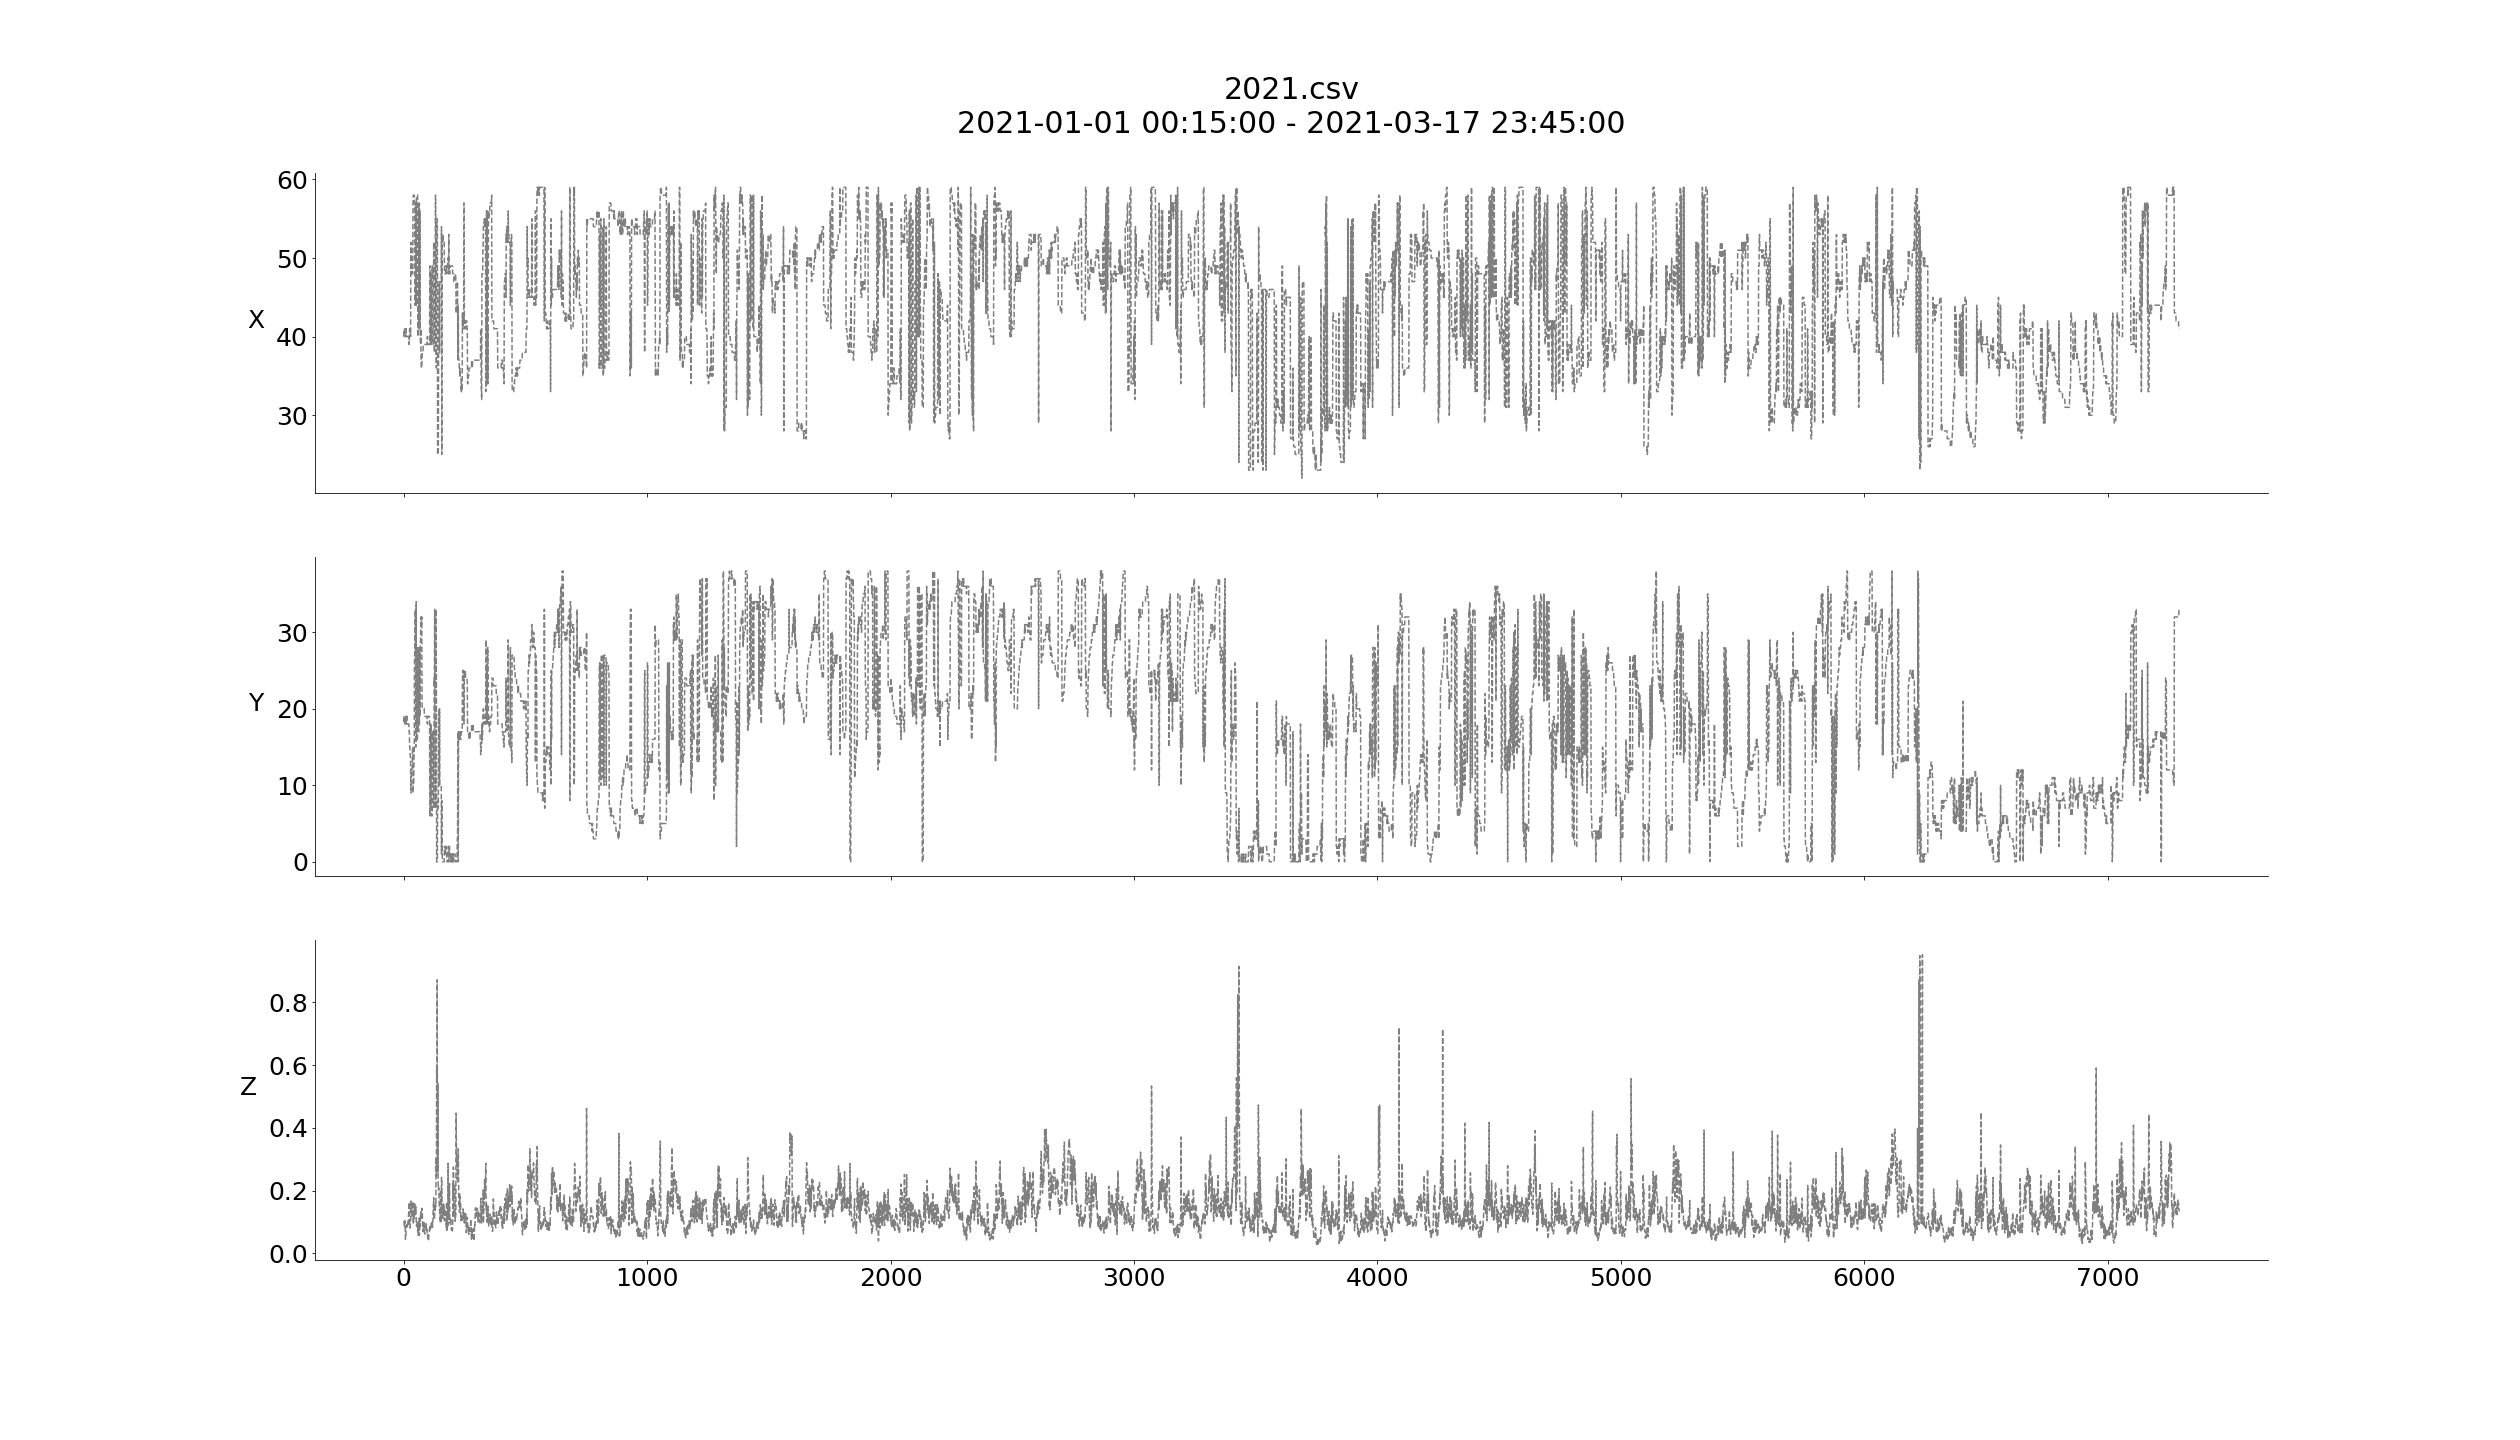

In [ ]:
Image(ENV_PATH+"/img/som/exp1/1D/2021.csv_76.png")

In [ ]:
import glob
plt.rcParams["figure.figsize"] = (15,9)
images = glob.glob(ENV_PATH+"/img/som/exp1/1D" + '/*.png')
for filename in images:
    img = plt.imread(filename)
    plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Image(ENV_PATH+"/img/som/exp1/3D/2021.csv_76.png")

In [ ]:
import glob
plt.rcParams["figure.figsize"] = (15,9)
images = glob.glob(ENV_PATH+"/img/som/exp1/3D" + '/*.png')
for filename in images:
    img = plt.imread(filename)
    plt.imshow(img)
    plt.show()

In [ ]:
plt.plot(X["Timestamp"], X["Chuva_alto_da_boa_vista"], label="Chuva_alto_da_boa_vista")
plt.plot(X["Timestamp"], X["Chuva_guaratiba"], label="Chuva_guaratiba")
plt.plot(X["Timestamp"], X["Chuva_iraja"], label="Chuva_iraja")
plt.plot(X["Timestamp"], X["Chuva_jardim_botanico"], label="Chuva_jardim_botanico")
plt.plot(X["Timestamp"], X["Chuva_rio_centro"], label="Chuva_rio_centro")
plt.plot(X["Timestamp"], X["Chuva_santa_cruz"], label="Chuva_santa_cruz")
plt.plot(X["Timestamp"], X["Chuva_sao_cristovao"], label="Chuva_sao_cristovao")
plt.legend(loc="best")
plt.show()

In [ ]:
Image(ENV_PATH+"/img/som/exp1/1D/2021.csv_76.png")

In [ ]:
Image(ENV_PATH+"/img/som/2021_anomaly.png")

In [ ]:
Image(ENV_PATH+"/img/som/exp2_anomalias.png")


In [ ]:
Image(ENV_PATH+"/img/som/chuva_ABV.png")

In [ ]:
Image(ENV_PATH+"/img/som/chuva_ABV_anomalia.png")

In [ ]:
del attr, X

In [ ]:
attt = ["target"]
attr = ["Chuva_alto_da_boa_vista",  "Temperatura_alto_da_boa_vista",  "Umidade_alto_da_boa_vista",
        "Chuva_guaratiba",          "Temperatura_guaratiba",          "Umidade_guaratiba",
        "Chuva_iraja",              "Temperatura_iraja",              "Umidade_iraja",
        "Chuva_jardim_botanico",    "Temperatura_jardim_botanico",    "Umidade_jardim_botanico",
        "Chuva_rio_centro",         "Temperatura_rio_centro",         "Umidade_rio_centro",
        "Chuva_santa_cruz",         "Temperatura_santa_cruz",         "Umidade_santa_cruz",
        "Chuva_sao_cristovao",      "Temperatura_sao_cristovao",      "Umidade_sao_cristovao"]

X = pd.read_csv(ENV_PATH+"/dat/2021.csv", encoding = 'utf-8', usecols=attr)
y = pd.read_csv(ENV_PATH+"/dat/2021.csv", encoding = 'utf-8', usecols=attt)

print("------------------------------------------------")
print("Basic description of features:")
print("------------------------------------------------")
print("Dataset shape:           ", X.shape)
print("Total samples:           ", len(X))
print("Total attributes:        ", np.size(attr))
print("Labels:                  ", y['target'].unique())
print("------------------------------------------------")
print("Nullity:")
print()
print(X.isnull().sum())
print("------------------------------------------------")

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer

impX  = SimpleImputer(missing_values=np.nan, strategy='mean')
impX  = impX.fit(X)    
impX  = impX.transform(X)
X     = pd.DataFrame(impX, columns=attr)

In [ ]:
X.head()

In [ ]:
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# **Unbalance analysis**

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({"font.size": 12})
sns.countplot(y["target"], palette="YlOrBr", edgecolor=sns.color_palette("dark", 3))
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Total")
plt.show()

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
over        = SMOTE(sampling_strategy=0.6)
under       = RandomUnderSampler(sampling_strategy=0.62)

steps       = [('o', over), ('u', under)]
pipeline    = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X, y["target"])

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({"font.size": 12})
sns.countplot(y_resampled, palette="YlOrBr", edgecolor=sns.color_palette("dark", 3))
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Total")
plt.show()

## **Rede Neural Recorrente: LSTM**

In [ ]:
print("-----------------------------------------------------")
print("Splitting the dataset into training and testing data:")
print("-----------------------------------------------------")
npX = X.to_numpy()
npy = y.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(npX, npy, train_size=0.70, test_size=0.30)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print()
print("X_test shape:  ", X_test.shape)
print("Y_test shape:  ", Y_test.shape)
print("-----------------------------------------------------")

In [ ]:
from keras.preprocessing import sequence
print("-----------------------------------------------------")
print("Handling data buffers:")
print("-----------------------------------------------------")
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print()
#21 attr  x  04inst = 1hrs = 084
#21 attr  x  12inst = 3hrs = 252
max_review_length   = 84
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test  = sequence.pad_sequences(X_test, maxlen=max_review_length)
print("-----------------------------------------------------")

In [ ]:
import math
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers.embeddings import Embedding

In [ ]:
print("-----------------------------------------------------")
print("Creation and fit the model:")
print("-----------------------------------------------------")
model           = Sequential()
embedding_layer = Embedding(input_dim       = int(len(X_train)),
                            output_dim      = max_review_length,
                            input_length    = int(len(X_train)))

model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(LSTM(21, activation='sigmoid', return_sequences=True))
model.add(LSTM(1,activation='sigmoid'))

model.compile(loss="binary_crossentropy", 
optimizer=keras.optimizers.Adam(learning_rate=0.001), 
metrics=['accuracy', 'mse', 'mae'])

history = model.fit(X_train, Y_train, epochs=3, batch_size=256, validation_data=(X_test, Y_test))
model.save(ENV_PATH+"/tmp/") 
print("-----------------------------------------------------")

In [ ]:
print("-----------------------------------------------------")
print("Model training results:")
print("-----------------------------------------------------")
scoresTrain = model.evaluate(X_train, Y_train, verbose=0)   
print("Train accuracy:          %.4f" % scoresTrain[1])
print("Train mse:               %.4f" % scoresTrain[2])
print("Train rmse:              %.4f" % math.sqrt(scoresTrain[2]))
print("Train mae:               %.4f" % scoresTrain[3])
print("-----------------------------------------------------")

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history["loss"])
pyplot.plot(history.history["val_loss"])
pyplot.title("Model fit")
pyplot.ylabel("Loss")
pyplot.xlabel("Epochs")
pyplot.legend(["Model training", "Test set"], loc="upper right")
pyplot.show()

In [ ]:
print("-----------------------------------------------------")
print("Test results:")
print("-----------------------------------------------------")
scoresTest      = model.evaluate(X_test, Y_test, verbose=0)
y_predict       = model.predict(X_test)
y_predict_round = np.around(y_predict)

rocTest         = roc_auc_score(Y_test, y_predict)
testAccuracy    = (accuracy_score(Y_test, y_predict_round))
testF1          = f1_score(Y_test, y_predict_round, average='binary')

print("ROC:             %.4f" % rocTest)
print("Accuracy:        %.4f" % testAccuracy)
print("f1_score-binary: %.4f" % testF1)
print()
print(classification_report(Y_test, y_predict_round))
print("-----------------------------------------------------")

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_predict)
auc_keras = auc(fpr_keras, tpr_keras)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_predict)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.plot(fpr_rf, tpr_rf, label="DT model (area = {:.3f})".format(auc_rf))
plt.xlabel("FN rate")
plt.ylabel("TP rate")
plt.title("ROC Curve (all data)")
plt.legend(loc='best')
plt.show()

In [ ]:
mc = confusion_matrix(Y_test, y_predict_round)
sns.heatmap(mc.T, square=True, annot=True, fmt="d", cbar=False, cmap="YlOrBr")
plt.xlabel('True Labels')
plt.ylabel('Predict Labels');
plt.show()

# **Model Evaluation (2020)**

In [ ]:
print("-----------------------------------------------------")
print("Loading the model:")
print("-----------------------------------------------------")
from keras.models import load_model
modelPath = ENV_PATH+"/tmp"
model     = load_model(modelPath)
model.summary()
print("-----------------------------------------------------")

In [ ]:
print("------------------------------------------------")
print("Loading the dataset 2020:")
print("------------------------------------------------")
print()
attr = ["target", "Timestamp",
        "Chuva_alto_da_boa_vista",  "Temperatura_alto_da_boa_vista",  "Umidade_alto_da_boa_vista",
        "Chuva_guaratiba",          "Temperatura_guaratiba",          "Umidade_guaratiba",
        "Chuva_iraja",              "Temperatura_iraja",              "Umidade_iraja",
        "Chuva_jardim_botanico",    "Temperatura_jardim_botanico",    "Umidade_jardim_botanico",
        "Chuva_rio_centro",         "Temperatura_rio_centro",         "Umidade_rio_centro",
        "Chuva_santa_cruz",         "Temperatura_santa_cruz",         "Umidade_santa_cruz",
        "Chuva_sao_cristovao",      "Temperatura_sao_cristovao",      "Umidade_sao_cristovao"]

valX = pd.read_csv(ENV_PATH+"/dat/2020.csv", encoding = 'utf-8', usecols=attr)

valX["Timestamp"]  = pd.to_datetime(valX["Timestamp"])
valX.index         = valX["Timestamp"]

#reserved for the next test [skip]
valX2 = valX

print()
print("------------------------------------------------")
print("Basic description of features:")
print("------------------------------------------------")
print("Dataset shape:           ", valX.shape)
print("Total samples:           ", len(valX))
print("Total attributes:        ", np.size(attr))
print("Labels:                  ", valX['target'].unique())
print("------------------------------------------------")
print("Total period of time:")    
print("------------------------------------------------")
print() 
beginDate   = valX.iloc[0]["Timestamp"]
endDate     = valX.iloc[-1]["Timestamp"]
print("Begin Date: ", beginDate)
print("End Date:   ", endDate)
print("------------------------------------------------")
print("Nullity:")
print()
print(valX.isnull().sum())
print("------------------------------------------------")

In [ ]:
print("------------------------------------------------")
print("Loading the dataset 2020:")
print("------------------------------------------------")
print()
attr = ["target", "Timestamp",
        "Chuva_alto_da_boa_vista",  "Temperatura_alto_da_boa_vista",  "Umidade_alto_da_boa_vista",
        "Chuva_guaratiba",          "Temperatura_guaratiba",          "Umidade_guaratiba",
        "Chuva_iraja",              "Temperatura_iraja",              "Umidade_iraja",
        "Chuva_jardim_botanico",    "Temperatura_jardim_botanico",    "Umidade_jardim_botanico",
        "Chuva_rio_centro",         "Temperatura_rio_centro",         "Umidade_rio_centro",
        "Chuva_santa_cruz",         "Temperatura_santa_cruz",         "Umidade_santa_cruz",
        "Chuva_sao_cristovao",      "Temperatura_sao_cristovao",      "Umidade_sao_cristovao"]

valX = pd.read_csv(ENV_PATH+"/dat/2020.csv", encoding = 'utf-8', usecols=attr)

valX["Timestamp"]  = pd.to_datetime(valX["Timestamp"])
valX.index         = valX["Timestamp"]

print()
print("------------------------------------------------")
print("Basic description of features:")
print("------------------------------------------------")
print("Dataset shape:           ", valX.shape)
print("Total samples:           ", len(valX))
print("Total attributes:        ", np.size(attr))
print("Labels:                  ", valX['target'].unique())
print("------------------------------------------------")
print("Total period of time:")    
print("------------------------------------------------")
beginDate   = valX.iloc[0]["Timestamp"]
endDate     = valX.iloc[-1]["Timestamp"]
print("Begin Date: ", beginDate)
print("End Date:   ", endDate)
print("------------------------------------------------")

In [ ]:
valX.head()

In [ ]:
valX  = valX.drop(columns=valX.columns[1])  
val_y = valX['target']
valY  = np.array(val_y)
valX  = valX.drop(columns=valX.columns[0])

In [ ]:
print("------------------------------------------------")
print("Nullity:")
print()
print(valX.isnull().sum())
print("------------------------------------------------")

In [ ]:
impX  = SimpleImputer(missing_values=np.nan, strategy='mean')
impX  = impX.fit(valX)    
impX  = impX.transform(valX)
valX  = pd.DataFrame(impX)

In [ ]:
from sklearn import preprocessing
min_max_scaler  = preprocessing.MinMaxScaler()
normX           = min_max_scaler.fit_transform(valX)
valX            = pd.DataFrame(data=normX)

In [ ]:
print("-----------------------------------------------------")
print("Handling data buffers:")
print("-----------------------------------------------------")
#21 attr  x  04inst = 1hrs = 084
#21 attr  x  12inst = 3hrs = 252
max_review_length   = 84
npvalX  = valX.to_numpy()
X_eval  = sequence.pad_sequences(npvalX, maxlen=max_review_length)
Y_eval  = valY
print("X_eval shape: ", X_eval.shape)
print("Y_eval shape: ", Y_eval.shape)
print("-----------------------------------------------------")

In [ ]:
print("-----------------------------------------------------")
print("Model Evaluation:")
print("-----------------------------------------------------")
evaluateModel     = model.evaluate(X_eval, Y_eval, verbose=0)
y_predEval        = model.predict(X_eval)
y_predEval_round  = np.around(y_predEval)

rocEval           = roc_auc_score(Y_eval, y_predEval)
f1Eval            = f1_score(Y_eval, y_predEval_round, average='binary')

print("ROC:             %.4f" % rocEval)
print("Accuracy:        %.4f" % evaluateModel[1])
print("f1_score-binary: %.4f" % f1Eval)
print()
print(classification_report(Y_eval, y_predEval_round))
print("-----------------------------------------------------")

In [ ]:
mc = confusion_matrix(Y_eval, y_predEval_round)
sns.heatmap(mc.T, square=True, annot=True, fmt="d", cbar=False, cmap="YlOrBr")
plt.xlabel('True Labels')
plt.ylabel('Predict Labels');
plt.show()

# <font color=#7325FC>**Loading another saved model (2021)**</font>

This model is exactly the same, but it was trained with 1000 iterations.

In [ ]:
print("-----------------------------------------------------")
print("Loading the model:")
print("-----------------------------------------------------")
from keras.models import load_model
modelPath = ENV_PATH+"/model/model"
model     = load_model(modelPath)
model.summary()
print("-----------------------------------------------------")

# **Train and test results**

In [ ]:
with open(ENV_PATH+"/model/2021.csv.out.fit_test.txt","r") as file:
    print(file.read())

In [ ]:
Image(ENV_PATH+"/model/2021.csv_loss_.png")

In [ ]:
Image(ENV_PATH+"/model/2021.csv_roc_.png")

In [ ]:
Image(ENV_PATH+"/model/2021.csv_mc_.png")

In [ ]:
Image(ENV_PATH+"/model/2021.csv_distr_sem_balanco_.png")

In [ ]:
Image(ENV_PATH+"/model/2021.csv_distr_com_balanco_.png")

**model evaluation (inference)**

Applied to the data of the three variables (rain, temperature and humidity)<br> of the seven meteorological stations,<br>for the same period of 2021 (from 01/01 to 03/17),<br>for the years 2016, 2017, 2018, 2019 and 2020.

## **2016**

In [ ]:
with open(ENV_PATH+"/model/out_pred_2016.csv.txt","r") as file:
    print(file.read())

## **2017**

In [ ]:
with open(ENV_PATH+"/model/out_pred_2017.csv.txt","r") as file:
    print(file.read())

# **2018**

In [ ]:
with open(ENV_PATH+"/model/out_pred_2018.csv.txt","r") as file:
    print(file.read())

# **2019**

In [ ]:
with open(ENV_PATH+"/model/out_pred_2019.csv.txt","r") as file:
    print(file.read())

# **2020**

In [ ]:
with open(ENV_PATH+"/model/out_pred_2020.csv.txt","r") as file:
    print(file.read())

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Done.
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *